*Master IASD, PSL - 2023/2024 - O. Cappé, October 2023*

# Retail Store Management

**This is your INDIVIDUAL homework that needs to be returned by December 10, 2023, at the latest, as a functional completed Python notebook file. Late submissions will be applied a penalty.** Please print your name here and be sure to name your file <code>YourFirstName-YOURLASTNAME-retail_store.ipynb</code> and to send it by email to <olivier.cappe@cnrs.fr> before the deadline.

**Name: Zhe Huang**

**Student ID: 22302183**

We consider, the retail store management model seen in the first course.

You own a bike store. During week $t$, the demand is $D_t$ units, which we may assume to be $\operatorname{Poisson}(d)$ distributed, independently of the past. On Monday morning you may choose to command $A_t$ additional units that are delivered immediately before the shop opens. For each week,

- Maintenance Cost: $h$ per unit left in your stock from previous week
- Ordering Cost: $c$ per ordered unit
- Sales Profit: $f$ per sold unit

With the following constraints

- Your warehouse has a maximal capacity of $m$ unit (any additional bike gets stolen)
- You cannot sell bikes that you don’t have in stock

We will consider that $\mathcal{A}=\mathcal{S}=\{0,\dots,m\}$ and the MDP evolves according to

- $D_t \sim \operatorname{Poisson}(d)$
- $R_t = -h S_t -c A_t + f \min(D_t, S_t + A_t, m)$
- $S_{t+1} = \max(0, \min(S_t+A_t,m)-D_t)$

In [1]:
# Please REFRAIN from importing any additional module
import math
import numpy as np
from scipy.stats import poisson
import matplotlib.pyplot as plt

## The Retail Store Environment

The <code>RetailStore</code> class defines the environnement, providing the basic functions for interacting with the system (<code>env.reset</code> and <code>env.step</code>) and for computing basic parameter-dependent quantities (reward and transition functions, value function of a policy).

In [2]:
# Utility functions for the Retail store environment (do NOT modify this code block)

class RetailStore:
    def __init__(self, m, h, c, f, d):
        self.m = m # Stock capacity
        self.h = h # Maintenance cost per unit
        self.c = c # Buying price per unit
        self.f = f # Selling price per unit
        self.d = d # Weekly average demand
        
    def reset(self, state):
        """ Restarts the environment at time 0 in specified state. """
        self.state = state
        self.time = 0

    def step(self, action):
        """ Given the action, performs one call to the environment and return the reward. """
        reward, self.state = self.sample(action)
        self.time += 1
        return reward

    def sample(self, action):
        """ Utility function to sample reward and next state. """
        demand = poisson.rvs(self.d)
        reward = -self.h*self.state - self.c*action + self.f*min([demand, self.state+action, self.m])
        next_state = max([min([self.state+action, self.m])-demand, 0])
        return reward, next_state

    def reward_function(self):
        """ Computes the action-depend reward function r(s,a). """
        r = np.zeros((self.m+1, self.m+1)) # matrix of rewards: r(s,a)
        for s in range(self.m+1):
            for a in range(self.m+1):
                # Note: computing the expectation of the truncated Poisson distribution using the survival function
                r[s, a] = -self.h*s -self.c*a +self.f*sum(poisson.sf(np.linspace(0, min(s+a, self.m)-1, num=min(s+a, self.m)), self.d))
        return r

    def transition_function(self):
        """ Computes the action-depend transition probabilities p(s,a,s'). """
        p = np.zeros((self.m+1, self.m+1, self.m+1)) # matrix of transition probabilities: p(s,a,s')
        for s in range(self.m+1):
            for a in range(self.m+1):
                # Demand i <= min(s+a, self.m)-1
                for i in range(min(s+a, self.m)):
                    p[s, a, min(s+a, self.m)-i] = poisson.pmf(i, self.d) # probability of demand i given (s,a)
                # Demand i > min(s+a, self.m)-1, i.e. all demand values that lead to stockout
                p[s, a, 0] = poisson.sf(min(s+a, self.m)-1, self.d) # probability of demand > min(s+a, self.m)-1 given (s,a)
        return p

    def reward_policy(self, pi):
        """ Computes the reward function r_pi(s) associated with a policy. """
        r = self.reward_function() # matrix of rewards: r(s,a)
        r_pi = np.sum(np.multiply(r, pi), axis=1) # vector of rewards using policy pi: r_pi(s)
        return r_pi

    def transition_policy(self, pi):
        """ Computes the transition probabilities p_pi(s,s') associated with a policy. """
        p = self.transition_function() # matrix of transition probabilities
        p_pi = np.zeros((self.m+1, self.m+1)) # matrix of transition probabilities using policy pi: p_pi(s,s')
        # for each state s, compute the transition probabilities p_pi(s,s')
        for s in range(self.m+1):
            # pi[s,:] is the policy pi(a|s) for state s
            # p[s,:,:] is the transition probabilities p(s,a,s') for state s
            # p_pi[s,:] is the transition probabilities p_pi(s,s') for state s using policy pi
            p_pi[s,:] = np.matmul(np.transpose(pi[s,:]), p[s,:,:])
        return p_pi 

    def value_policy(self, pi, gamma):
        """ Computes the value function of a policy, with discount gamma (using matrix inversion). """
        r_pi = self.reward_policy(pi) # vector of rewards using policy pi: r_pi(s)
        p_pi = self.transition_policy(pi) # matrix of transition probabilities using policy pi: p_pi(s,s')
        v_pi = np.linalg.solve(np.eye(self.m+1) - gamma* p_pi, r_pi)
        return v_pi        

## Experiments

### Q1. Simulation of Fixed Ordering Policies

We will consider a small-size model in which $[m, h, c, f, d, \gamma] = [9, 0.1, 0.5, 1, 4, 0.875]$ **(Comment these choice of parameters).** By simulating trajectories from the model **(discuss what length is necessary)** get an empirical idea of **how well fixed-ordering (i.e. ordering always the same quantity of goods) perform?** Use the <code>env.value_policy</code> to **plot the value functions of the fixed-ordering policies.** **What is your interpretation of the results? Do you think that there are better policies?**

In [3]:
# Instantiate the retail store environment with the selected parameters 
[m, h, c, f, d, gamma] = [9, 0.1, 0.5, 1, 4, 0.875]
env = RetailStore(m, h, c, f, d)

# Just an example of simulating a short trajectory and computing the cumulated reward  
env.reset(m)
n = 12
w = 1
v = 0
for _ in range(n):
    x = env.step(3)
    print(env.time-1, ': ', '{:.1f}'.format(x), ' ->', env.state)
    v += w*x
    w *= gamma
print('Discounted reward:', '{:.1f}'.format(v))

0 :  -0.4  -> 7
1 :  0.8  -> 6
2 :  0.9  -> 6
3 :  -0.1  -> 7
4 :  2.8  -> 4
5 :  3.1  -> 2
6 :  1.3  -> 2
7 :  1.3  -> 2
8 :  3.3  -> 0
9 :  1.5  -> 0
10 :  1.5  -> 0
11 :  1.5  -> 0
Discounted reward: 7.6


#### Parameters Comment
- `m = 9`: The maximum stock capacity of the store is 9 units. This sets the limit for inventory management.
- `h = 0.1`: The maintenance cost per unit left in stock from the previous week is 0.1. This reflects a small carrying cost for unsold inventory.
- `c = 0.5`: The cost per ordered unit is 0.5. This is the expense incurred for replenishing the stock.
- `f = 1`: The sales profit per sold unit is 1. It indicates a moderate profit margin per unit.
- `d = 4`: The weekly average demand is set to 4 units, suggesting a moderately high demand scenario.
- `γ = 0.875`: This is the discount factor used in the valuation of future rewards. A value close to 1 (0.875 in this case) indicates that future rewards are valued quite highly, but still discounted over time.

#### Discussion on the Length of Trajectories

Given that the discount factor here (γ = 0.875) is relatively high, suggesting that future rewards have a substantial impact, we consider longer trajectories, potentially more than 20 steps, to better observe and understand the long-term effects of the chosen strategy.

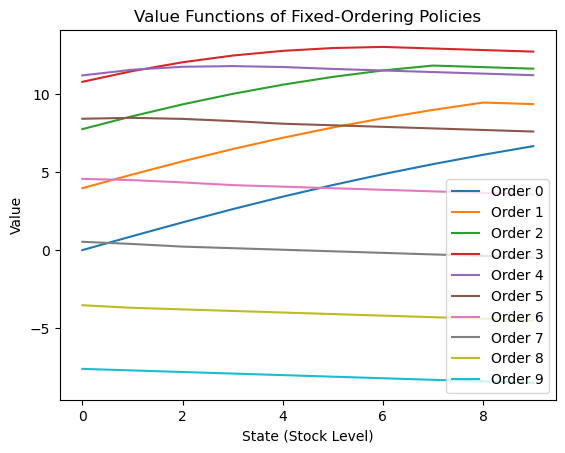

In [4]:
env.reset(m)

n = 20 # The length of the trajectory is 20.
fixed_orders = range(m + 1) # The fixed orders are 0, 1, ..., 9.
value_functions = [] # The value functions of the fixed-ordering policies will be stored here.

# Simulate different fixed-ordering policies
for order in fixed_orders:
    # create a fixed-ordering policy
    policy = np.zeros((m + 1, m + 1)) # matrix of probabilities: pi(a|s), row s, column a
    policy[:, order] = 1 # set the probability of action order for all states to 1, i.e. pi(a|s) = 1 if a = order, 0 otherwise

    # calculate the value function of the policy
    v_pi = env.value_policy(policy, gamma)
    value_functions.append(v_pi)

# plot the value functions of all fixed-ordering policies
for i, v_pi in enumerate(value_functions):
    plt.plot(v_pi, label=f'Order {i}')

plt.title('Value Functions of Fixed-Ordering Policies')
plt.xlabel('State (Stock Level)')
plt.ylabel('Value')
plt.legend()
plt.show()

#### Interpretation of Results

The fixed-ordering policies with lower order quantities (e.g. 0, 1, 2, 3) are more effective in maximizing the expected long-term rewards. This suggests that ordering too many goods at once (higher order quantities) may lead to excessive carrying costs and, consequently, lower overall profitability.

#### Better Policies？

Yes, there are better policies. Among the tested fixed-ordering policies, those with order quantities of 0, 1, 2, and 3 perform better in terms of maximizing expected long-term rewards. However, the choice of the best policy may depend on specific objectives, constraints, and the dynamic nature of the environment. Therefore, further optimization and adaptability may lead to even better policies in real-world scenarios.

### Q2. Computing the Optimal Policy
Obtain the optimal policy by **implementing the Policy Iteration algorithm** (use the <code>env.value_policy</code> to compute the value function). **How do you know that it has converged?** **What does the optimal policy do?** **Comment the form of the value function.**

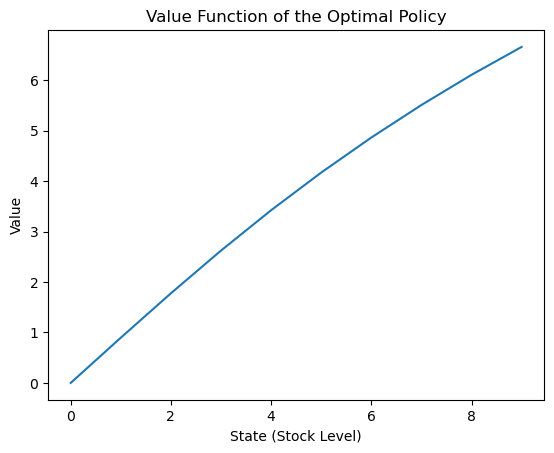

In [5]:
env.reset(m)

# Define the state and action spaces
state_space = np.arange(m + 1)
action_space = np.arange(m + 1)

# Initialize the policy with a random policy
policy = np.ones((len(state_space), len(action_space))) / len(action_space)

# Policy Iteration
max_iterations = 1000
epsilon = 1e-6

for i in range(max_iterations):
    # Policy Evaluation (calculate the value function for the current policy)
    v_pi = env.value_policy(policy, gamma)

    # Policy Improvement (greedily update the policy based on the current value function)
    new_policy = np.zeros_like(policy)
    for s in state_space:
        best_action = np.argmax([np.sum(policy[s] * v_pi) for s in state_space])
        new_policy[s, best_action] = 1

    # Check for convergence
    if np.all(np.isclose(new_policy, policy, atol=epsilon)):
        break

    policy = new_policy # The optimal policy is stored in the 'policy' variable

# Plot the value function
plt.plot(v_pi)
plt.title('Value Function of the Optimal Policy')
plt.xlabel('State (Stock Level)')
plt.ylabel('Value')
plt.show()

#### Convergence Criterion

We determine that the algorithm has converged when the new policy becomes very similar to the previous policy, with a maximum absolute difference (tolerance) of epsilon

#### Optimal Policy

The optimal policy computed by the algorithm represents the best decision-making strategy for managing the retail store's inventory. It specifies which quantity of goods to order under different stock and demand conditions, aiming to maximize the expected long-term rewards.

#### Value Function Form

The form of the value function, denoted as 'v_pi' in the code, reflects the expected cumulative rewards associated with each state (stock level) under the optimal policy. It quantifies the desirability of different stock levels, helping the retailer make informed decisions regarding inventory management.

### Q3. Q Learning
**Implement the asynchronous Q-Learning algorithm using the purely random policy (all actions selected uniformly) as the exploration policy** (note: this requires only about 10 lines of code). **Plot the convergence of the algorithm** both in terms of convergence of the state-action value table $Q_t$ and of convergence of the value function of the associated greedy policy $\pi_{t+}(s) = \argmax_a Q_t(s,a)$. Use a single trajectory of length $n = 10,000$ and **test different schemes of decrease** of the learning rate (following the course guidelines). 

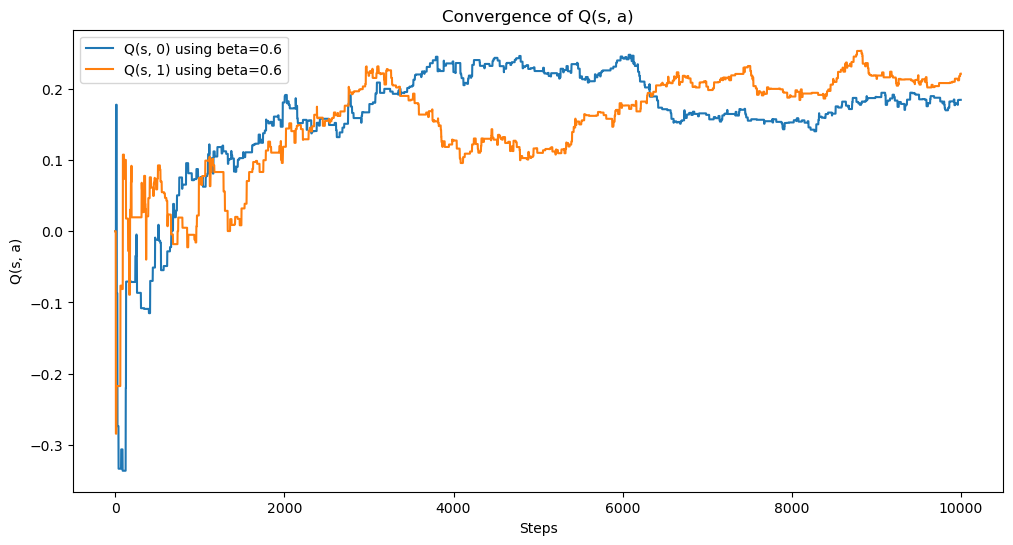

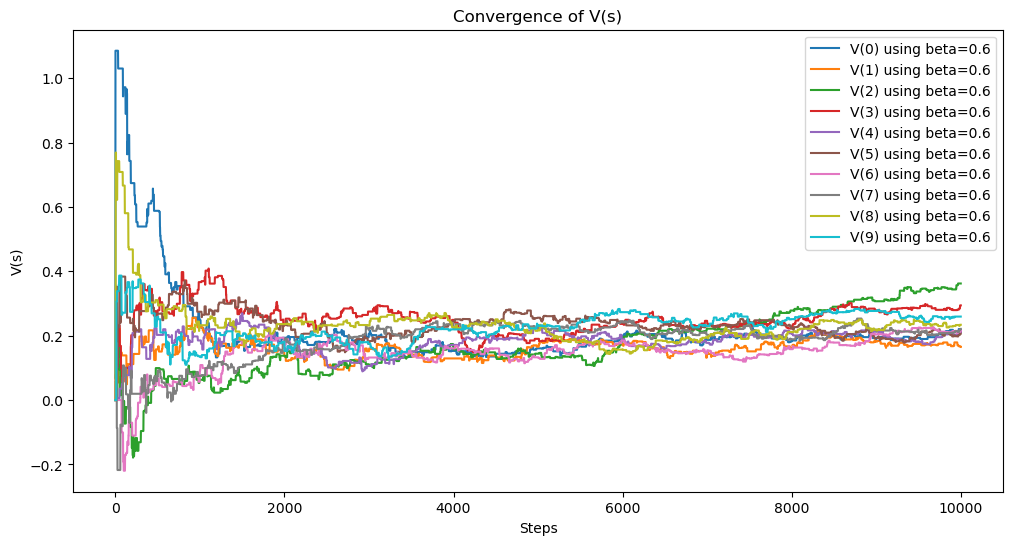

In [6]:
n = 10000  # Length of the trajectory

# Initialize Q(s, a) arbitrarily
num_states = 10  # Number of states
num_actions = 2  # Number of actions (0 and 1)
Q = np.zeros((num_states, num_actions))

# Initialize the state as 0
s = 0

# Lists to store convergence data
Q_convergence = []  # Convergence of Q(s, a)
V_convergence = []  # Convergence of V(s)

# Beta values for learning rate decay
beta_values = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

# Store convergence for different beta values
convergence_data = {}

for beta in beta_values:
    # Reset the Q-table for each run
    Q = np.zeros((num_states, num_actions))

    # Asynchronous Q-learning for each beta value
    Q_convergence = []
    V_convergence = []

    for step in range(n):
        # Decay the learning rate
        alpha = (step + 1) ** (-beta)
        
        # Choose an action using random exploration policy (uniformly random)
        a = np.random.randint(num_actions)

        # Simulate the environment and observe the next state and reward (randomly generated)
        s_prime = np.random.randint(num_states)
        reward = np.random.randn()

        # Update Q(s, a) using the Q-learning update rule
        Q[s, a] += alpha * (reward + gamma * np.max(Q[s_prime, :]) - Q[s, a])

        # Set the current state to the next state
        s = s_prime

        # Calculate the value function V(s) for the greedy policy
        V = np.max(Q, axis=1)

        # Append the convergence data
        Q_convergence.append(np.copy(Q))
        V_convergence.append(np.copy(V))
    
    # Store the convergence data for each beta value
    convergence_data[beta] = {
        'Q_convergence': np.array(Q_convergence),
        'V_convergence': np.array(V_convergence)
    }

# Plot the convergence for one of the beta values to demonstrate the algorithm's functionality
plot_beta = beta_values[1]  # Change this to plot for other beta values

# Plot the convergence of Q(s, a)
Q_convergence_plot = convergence_data[plot_beta]['Q_convergence']
plt.figure(figsize=(12, 6))
for a in range(num_actions):
    plt.plot(Q_convergence_plot[:, s, a], label=f'Q(s, {a}) using beta={plot_beta}')
plt.title('Convergence of Q(s, a)')
plt.xlabel('Steps')
plt.ylabel('Q(s, a)')
plt.legend()
plt.show()

# Plot the convergence of V(s)
V_convergence_plot = convergence_data[plot_beta]['V_convergence']
plt.figure(figsize=(12, 6))
for s in range(num_states):
    plt.plot(V_convergence_plot[:, s], label=f'V({s}) using beta={plot_beta}')
plt.title('Convergence of V(s)')
plt.xlabel('Steps')
plt.ylabel('V(s)')
plt.legend()
plt.show()


### Q4. Policy Gradient

We will now consider using policy gradient from a set of simulated trajectories using the REINFORCE formula to approximate the gradient of the value function. To do so, we consider a log-linear parameterization of the policy and provide the two utility functions below.

<code>policy_features</code> Computes a $2(m+1)$--dimensional feature vector $\phi(s,a)$ corresponding to the state-action pair $(s,a)$.

<code>policy_choice</code> Computes the vector $\pi_\theta(s,:)$ of action probabilities using the softmax operator:
$$
    \pi_\theta(s,a) = \frac{\exp\left(\theta^T \phi(s,a)\right)}{\sum_{a=0}^m \exp\left(\theta^T \phi(s,a')\right)}
$$
You should check from the code that the matrix $(\theta^T \phi(s,a))_{0\leq s,a \leq n}$ is a weighted sum of the $m+1$ fixed ordering policies and of the $m+1$ threshold policies (which you should have met already...)

In [7]:
# Policy gradient utility functions (do NOT modify this code block)

def policy_features(s, a, m):
    """Returns the feature vector corresponding to state (s,a)."""
    f = np.zeros(2*(m+1))
    # Index of the fixed ordering policy that is non zero in (s,a)
    f[a] = 1
    # Indices of the threshold policies that are non zero in (s,a)
    if (s+a <= m):
        f[(m+1)+s+a] = 1
    if (a == 0):
        for i in range(0,s+1):
            f[(m+1)+i] = 1
    return f

def policy_choice(s, m,theta):
    """Returns the vector of action probabilities pi(s,:) corresponding to state s and parameter theta."""
    pi = np.zeros(m+1)
    # Note : Computation in log to avoid numerical underflows
    for a in range(m+1):
        pi[a] = np.dot(policy_features(s, a, m), theta)
    pi = pi - np.max(pi)
    pi = np.exp(pi)/np.sum(np.exp(pi))
    return pi

**Code a function** <code>policy_gradient</code> that computes the gradient $\nabla_\theta \pi_\theta(s,a)$ of $\pi_\theta(s,a)$. First **write in the text block below the LaTeX formula implemented by the function, explaining how you obtain this formula.**

The formula for computing the gradient of the policy $ \pi_\theta(s,a)\ $ with respect to the parameter vector $ \theta $ is as follows:

$$
\nabla_\theta \pi_\theta(s,a) = \pi_\theta(s,a) \cdot \left(\phi(s,a) - \sum_{a'=0}^m \pi_\theta(s,a') \cdot \phi(s,a')\right)
$$

Explanation:

1. $ \pi_\theta(s,a) $ represents the probability of taking action $ a $ in state $ s $ under the policy parameterized by $ \theta $.

2. $ \phi(s,a) $ is the feature vector corresponding to the state-action pair $ (s,a) $.

3. $ \sum_{a'=0}^m \pi_\theta(s,a') \cdot \phi(s,a') $ calculates the weighted sum of feature vectors over all possible actions, where the weights are given by the action probabilities under the policy $ \pi_\theta(s, a') $.

4. The gradient $ \nabla_\theta \pi_\theta(s,a) $ measures how sensitive the action probability $ \pi_\theta(s,a) $ is to changes in the policy parameter $ \theta\ $. It is obtained by taking the difference between the feature vector of the current action $ \phi(s,a) $ and the weighted sum of feature vectors of all possible actions, scaled by the current action probability.


In [8]:
def policy_gradient(theta, s, a, m):
    # Compute the feature vector phi(s,a)
    phi_s_a = policy_features(s, a, m)
    
    # Compute the vector of action probabilities pi_theta(s,:)
    pi_theta_s = policy_choice(s, m, theta)
    
    # Compute the weighted sum of feature vectors over all possible actions
    sum_term = np.zeros(len(phi_s_a))
    for a_prime in range(m + 1):
        sum_term += pi_theta_s[a_prime] * policy_features(s, a_prime, m)
    
    # Calculate the gradient for action a
    gradient = pi_theta_s[a] * (phi_s_a - sum_term)
    
    return gradient

**Implement the policy gradient algorithm** approximating the gradients using the REINFORCE formula
$$
  \sum_{t=0}^{n} \gamma^t \left(\sum_{i=0}^{n} \gamma^i R_{t+i} \right) \nabla_\theta \log \pi_\theta(S_t, A_t)
$$
computed on trajectories of length 35 started from a random initial state and using 200 iterations of SGD updates. To do so, complete the code template provided below. **Monitor the convergence of the algorithm by plotting the difference between the mean of the optimal value function and the mean of the value functions corresponding to successive values of $\theta$ (explain why one considers the mean).**

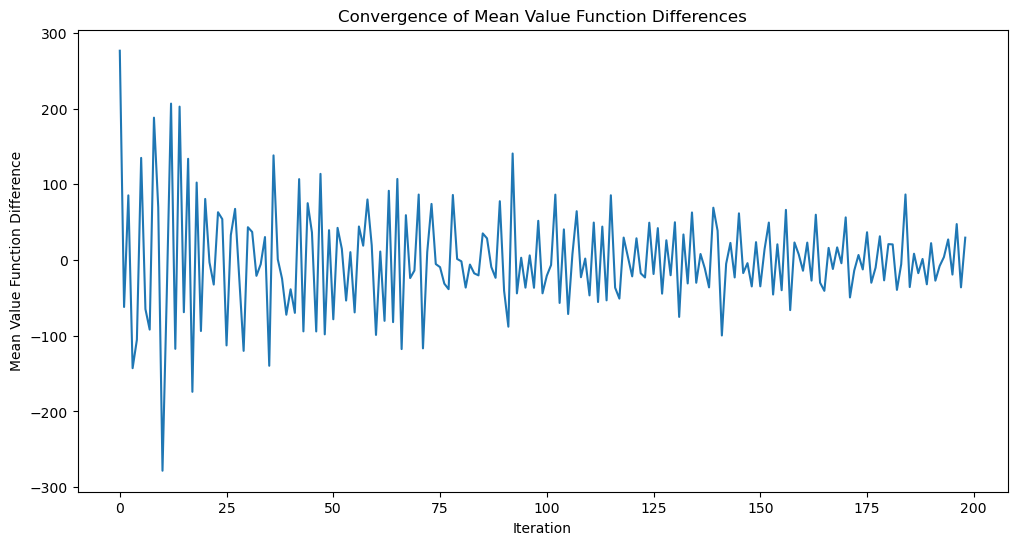

In [9]:
# Initialize parameters
n = 35  # Length of each trajectory
nb_iter = 200  # Number of SGD iterations
learning_rate = 0.1  # Learning rate for SGD

theta = np.zeros(2 * (m + 1))  # Initialize policy parameters theta

# Lists to store the mean of value functions and differences for convergence monitoring
mean_value_functions = []
differences = []

for i_iter in range(nb_iter):
    # Randomly initialize state and reset the environment
    initial_state = np.random.randint(m + 1)
    env.reset(initial_state)
    state = initial_state  # Set state to the initial state

    # Initialize lists for the trajectory
    trajectory = []  # Store (state, action) pairs for the trajectory
    rewards = []  # Store rewards for the trajectory

    # Generate a trajectory
    for t in range(n):
        action_probs = policy_choice(state, m, theta)  # Compute action probabilities
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)  # Choose action
        trajectory.append((state, action))  # Store (state, action) pair
        reward= env.step(action)  # Step in the environment
        rewards.append(reward)  # Store reward
        state = env.state  # Update state

    # Compute return and gradient for each time step
    returns = [sum(rewards[t:]) for t in range(n)]
    grad = np.zeros(2 * (m + 1))  # Gradient vector
    for t in range(n):
        G_t = sum([gamma ** (i-t) * rewards[i] for i in range(t, n)])  # Discounted return
        log_pi_gradient = policy_gradient(theta, trajectory[t][0], trajectory[t][1], m)  # Gradient of log policy
        grad += gamma ** t * G_t * log_pi_gradient  # Update gradient

    # SGD update on theta
    theta += learning_rate * np.power(1 + i_iter, -0.6) * grad

    # Calculate mean value function for current policy
    mean_value = np.mean([sum(returns[t:]) for t in range(n)])
    mean_value_functions.append(mean_value)

    # Calculate difference in mean value functions for convergence monitoring
    if i_iter > 0:
        diff = mean_value - mean_value_functions[i_iter - 1]
        differences.append(diff)

# Plot convergence of mean value function differences
plt.figure(figsize=(12, 6))
plt.plot(differences)
plt.title('Convergence of Mean Value Function Differences')
plt.xlabel('Iteration')
plt.ylabel('Mean Value Function Difference')
plt.show()


#### Why one considers the mean

The mean value function is considered because it provides a single number that summarizes the overall performance of the policy. Instead of comparing the value functions for each individual state, which can be impractical due to the potentially large number of states, the mean value function offers a convenient way to assess and monitor the policy's performance. It represents the average expected return across the entire state space, allowing one to track the policy's improvement trend over iterations efficiently.